<a href="https://colab.research.google.com/github/happyrabbit/IntroDataScience/blob/master/Python/TreeBasedModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tree-based Models notebook

In this notebook, we will use Python to fit regression and classfication tree models, as well as extentions such as random forest and gradient boosted trees.

In [35]:
# Load packages
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import sklearn.model_selection as ms
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
# Read data
dat = pd.read_csv("http://bit.ly/2P5gTw4")
dat[:6]

,age,gender,income,house,store_exp,online_exp,store_trans,online_trans,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,segment
0,57,Female,120963.400958,Yes,529.134363,303.512475,2,2,4,2,1,2,1,4,1,4,2,4,Price
1,63,Female,122008.104950,Yes,478.005781,109.529710,4,2,4,1,1,2,1,4,1,4,1,4,Price
2,59,Male,114202.295294,Yes,490.810731,279.249582,7,2,5,2,1,2,1,4,1,4,1,4,Price
3,60,Male,113616.337078,Yes,347.809004,141.669752,10,2,5,2,1,3,1,4,1,4,2,4,Price
4,51,Male,124252.552787,Yes,379.625940,112.237177,4,4,4,1,1,3,1,4,1,4,2,4,Price
5,59,Male,107661.456130,Yes,338.315403,195.687013,4,5,4,2,1,2,1,4,1,4,1,4,Price


# 01-Regression Tree

In [32]:
# data cleaning: delete wrong observations
dat = dat[dat.store_exp > 0]
dat = dat[dat.online_exp > 0]

# use the 10 survey questions as predictors
x = dat.filter(regex = "^Q")

# use the sum of store and online expenditure as response variable
# total expenditure = store expenditure + online expenditure
y = dat.store_exp + dat.online_exp

We split the data into training and testing:

In [50]:
xtrain, xtest, ytrain, ytest = ms.train_test_split(x, y, test_size = 0.2, random_state = 1)

Let's define values over which over which our search will be performed

In [51]:
depth_val = np.arange(1, 11)
grid_tune = [{'max_depth': depth_val}]

In [52]:
# instantiate the tree model 
tree_model = tree.DecisionTreeRegressor()	

Run the search and use the best parameters found. Here we use 10 fold cross-validation. 

In [53]:
cv_tree = GridSearchCV(estimator = tree_model,
                       param_grid = grid_tune,
                       cv = ms.KFold(n_splits = 10))
fit_model = cv_tree.fit(xtrain, ytrain)	

In [61]:
# get the best max_depth
best_depth = fit_model.best_params_["max_depth"]
best_depth

2

In this case, the best maximum depth is 2. Let us apply the model to the testing subset:

In [57]:
tree_model = tree.DecisionTreeRegressor(max_depth = best_depth)
train_model = tree_model.fit(xtrain, ytrain)
ypred = train_model.predict(xtest)

You can get the mean absolute error:

In [59]:
metrics.mean_absolute_error(ytest, ypred)

381.41288147147645

We can generate a Graphviz visualisation of the tree we have.

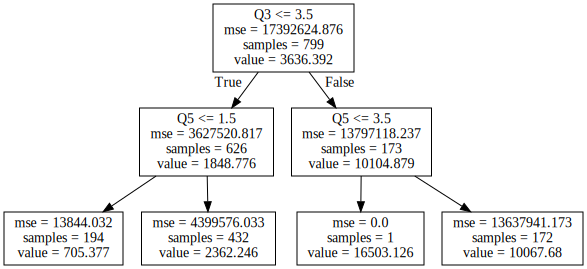

In [65]:
import graphviz			
display(graphviz.Source(tree.export_graphviz(train_model, max_depth = best_depth, feature_names = xtrain.columns)))

# 02-Decision Tree

In [9]:
# use the 10 survey questions as predictors
x = dat.filter(regex = "^Q")

# use gender as the response variable
# convert it to be numerical with "Female" = 1
y = pd.get_dummies(dat, columns = ['gender']).gender_Female 

# split the data into training and testing
xtrain, xtest, ytrain, ytest = ms.train_test_split(x, y, test_size = 0.2, random_state = 1)

In [12]:
depth_val = np.arange(1, 11)
grid_tune = [{'max_depth': depth_val}]

# instantiate the tree model 
tree_model = tree.DecisionTreeClassifier(criterion = "entropy")	

# 10 fold cross-validatioon
cv_tree = GridSearchCV(estimator = tree_model,
                       param_grid = grid_tune,
                       cv = ms.KFold(n_splits = 10))
fit_model = cv_tree.fit(xtrain, ytrain)	

# get the best max_depth
best_depth = fit_model.best_params_["max_depth"]

Let us apply the model to the testing subset:

In [67]:
tree_model = tree.DecisionTreeClassifier(max_depth = best_depth)
train_single_tree = tree_model.fit(xtrain, ytrain)
ypred = train_single_tree.predict_proba(xtest)[::,1]

# get AUC score
metrics.roc_auc_score(ytest, ypred)

0.6414322250639386

# 03-Ensemble Tree Models

We use the data for the above decision tree example to show different ensemble tree models. So the followings are all decision trees. You can build regression trees in very similar manners by using `DecisionTreeRegressor()`.

In [85]:
# use the 10 survey questions as predictors
x = dat.filter(regex = "^Q")

# use gender as the response variable
# convert it to be numerical with "Female" = 1
y = pd.get_dummies(dat, columns = ['gender']).gender_Female 

# split the data into training and testing
xtrain, xtest, ytrain, ytest = ms.train_test_split(x, y, test_size = 0.2, random_state = 1)

## 03.1-Bagging

We use `RandomizedSearchCV` from `sklearn` to optimize our hyperparamaters. For bagging, we focus on the following hyperparameters:
1. `n_estimators`: The number of trees in the bagging model.

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# create random grid
bag_grid = {
 'n_estimators': n_estimators
 }

bag = BaggingClassifier()

# Random search of parameters
bag_tune = RandomizedSearchCV(estimator = bag, 
                              param_distributions = bag_grid, 
                              cv = 10, verbose = 0, random_state = 1)

train_bag = bag_tune.fit(xtrain, ytrain)

In [50]:
# Best hyperparameter value
train_bag.best_params_['n_estimators']

600

Use the tuned hyperparameter to train the model. 

In [66]:
bag = BaggingClassifier(n_estimators = train_bag.best_params_['n_estimators'])
bag_fit = bag.fit(xtrain, ytrain)
ypred = train_bag.predict_proba(xtest)[::,1]

# check the auc
metrics.roc_auc_score(ytest, ypred)

0.6742199488491049

## 03.2-Random Forest

For random forest, we focus on the following hyperparameters:
1. `n_estimators`: The number of trees in the forest
1. `max_features`: The number of features to consider when looking for the best split

In [52]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = [i for i in range(2,8)]

# create random grid
rf_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features
 }

rf = RandomForestClassifier()

# Random search of parameters
rf_tune = RandomizedSearchCV(estimator = rf, 
                              param_distributions = rf_grid, 
                              cv = 10, verbose = 0, random_state = 1)

train_rf = rf_tune.fit(xtrain, ytrain)

In [54]:
# Best hyperparameter value
train_rf.best_params_

{'max_features': 4, 'n_estimators': 1600}

In [65]:
rf = RandomForestClassifier(n_estimators = train_rf.best_params_['n_estimators'], max_features = train_rf.best_params_['max_features'])
rf_fit = rf.fit(xtrain, ytrain)
ypred = rf_fit.predict_proba(xtest)[::,1]

# check the auc
metrics.roc_auc_score(ytest, ypred)

0.6745268542199487

## 03.3-Gradient Boosting

We focus on the following hyperparameters:
1. `n_estimators`: The number of boosting stages to perform. 
1. `learning_rate`: learning rate shrinks the contribution of each tree. There is a trade-off between `learning_rate` and `n_estimators`.
1. `min_samples_leaf`: The minimum number of samples required to be at a leaf node.
1. `max_features`: The number of features to consider when looking for the best split

In [58]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
learning_rate = [0.01, 0.1]
min_samples_leaf = [i for i in range(1,11)]
max_features = [i for i in range(2,8)]

# create random grid
gbm_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'learning_rate': learning_rate,
 'min_samples_leaf': min_samples_leaf
 }


gbm = GradientBoostingClassifier()

# Random search of parameters
gbm_tune = RandomizedSearchCV(estimator = gbm, 
                              param_distributions = gbm_grid, 
                              cv = 10, verbose = 0, random_state = 3)

train_gbm = gbm_tune.fit(xtrain, ytrain)

In [60]:
train_gbm.best_params_

{'learning_rate': 0.01,
 'max_features': 4,
 'min_samples_leaf': 6,
 'n_estimators': 1400}

In [63]:
gbm = GradientBoostingClassifier(n_estimators = train_gbm.best_params_['n_estimators'],
                                max_features = train_gbm.best_params_['max_features'],
                                min_samples_leaf = train_gbm.best_params_['min_samples_leaf'],
                                learning_rate = train_gbm.best_params_['learning_rate'])
gbm_fit = gbm.fit(xtrain, ytrain)
ypred = gbm_fit.predict_proba(xtest)[::,1]

# check the auc
metrics.roc_auc_score(ytest, ypred)

0.6786700767263427

## 03.4-Compare classifiers

In [70]:
# List of trained classifier
classifiers = [train_single_tree, bag_fit, rf_fit, gbm_fit]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])


for cls in classifiers:
    yproba = cls.predict_proba(xtest)[::,1]
    
    fpr, tpr, _ = roc_curve(ytest,  yproba)
    auc = metrics.roc_auc_score(ytest, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)
# create a list of model names
model_names = ['Single Tree','Bagging', 'Random Forest', 'Gradient Boostiing']

Plot the figure

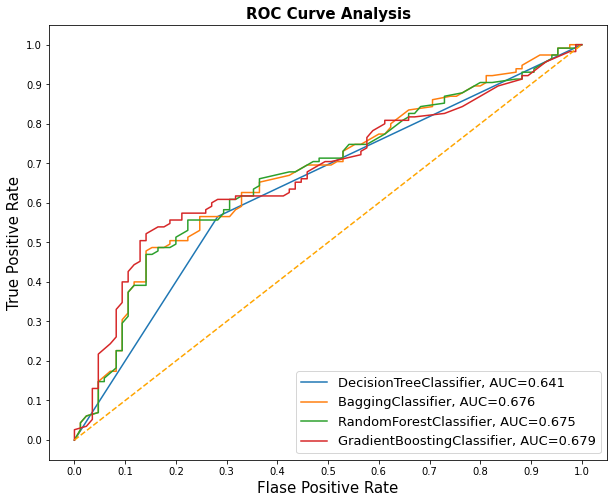

In [72]:
fig = plt.figure(figsize=(10,8))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()